<a href="https://colab.research.google.com/github/aimldlnn/rtxaiml20220214/blob/main/Using_OpenCV_to_Classify_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Keras and OpenCV to Classify Images

Here we will take an trained Imagenet model and perform inference on an image we give the model.

**Author**: W. Tod Newman
##Learning Objectives

   *  Understand how to easly use OpenCV and Imagenet pretrained models in Keras
   *  Evaluate the way that these models classify known images
   *  Develop understanding of transfer learning and these models in particular.

## What is a pre-trained model?
A pre-trained model is trained on a different task than the task at hand but provides a very useful starting point because the features learned while training on the old task are useful for the new task.  To find these in keras go to https://keras.io/applications/

## What is Imagenet?
Imagenet is a project created to provide a large image database for research purposes. It contains more than 14 million images which belong to more than 20,000 classes. They also provide bounding box annotations for around 1 million images, which can be used in Object Localization tasks. 

## Pre-trained models already part of Keras
From the ImageNet Large Scale Visual Recognition Challenge  (ILSVRC)  many winning models have been open-sourced. 

These networks are trained for classifying images into one of 1000 categories or classes.

Keras comes bundled with many models. A trained model has two parts – Model Architecture and  Weights. The weights are large files and have to be automatically downloaded ( one-time ). For this example we'll focus on three architectures and we'll instantiate them with imagenet weights.

* VGG16.  A 16 Layer Convolutional Network created by Oxford's Visual Geometries Group that won ILSVRC in 2014.  https://arxiv.org/abs/1409.1556
* DenseNet 121.  A CNN with Dense Connections between layers.  https://arxiv.org/abs/1608.06993
* ResNet 50.  A 50 layer residual network.  https://arxiv.org/pdf/1512.03385.pdf

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import vgg16, resnet50, densenet
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')
  
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')

# Load the DenseNet Model
densenet_model = densenet.DenseNet121(weights='imagenet')

# Clone the images repository
!git clone https://github.com/todnewman/images
%cd /content/images
!ls -l

33202176/33188688 [==============================] - 0s 0us/step
Cloning into 'images'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 34 (delta 4), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (34/34), done.
/content/images
total 164
-rw-r--r-- 1 root root  8420 Oct 28 16:26  air-combat.jpg
-rw-r--r-- 1 root root 15223 Oct 28 16:26  bed-bugsalt.jpg
-rw-r--r-- 1 root root  9176 Oct 28 16:26  carrier.jpg
-rw-r--r-- 1 root root  3123 Oct 28 16:26  commercial_aircraft.jpg
-rw-r--r-- 1 root root  4283 Oct 28 16:26  dog.jpg
-rw-r--r-- 1 root root 17200 Oct 28 16:26 'finch from feeder.jpg'
-rw-r--r-- 1 root root 11361 Oct 28 16:26  goldfinch.jpg
-rw-r--r-- 1 root root 76868 Oct 28 16:26  molly.jpg
-rw-r--r-- 1 root root    35 Oct 28 16:26  README.md


In [ ]:
# Here's a cool way to see the layers in the models.  Substitute the name of the model you're interested in
print (resnet_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Function to predict the Image Class

Feed the processed image to the network and get the predictions. The image we got in the previous step should be normalized by subtracting the mean of the ImageNet data. This is because the network was trained on the images after this pre-processing. We follow the following steps to get the classification results.

1) **Preprocess** the input by subtracting the mean Imagenet RGB value from each channel of the images in the batch. This is done using the preprocess_input() function.

2) Get the classification result, which is a Tensor of dimension ( batchsize x 1000 ). This is done by model.predict() function.

3) Convert the result to human-readable labels – The vector obtained above has too many values to make any sense. Keras provides a function decode_predictions() which takes the classification results, sorts it according to the confidence of prediction and gets the class name ( instead of a class-number).The output shows the class ID, class name and the confidence of prediction.

In [ ]:
# Small Function intended to walk through a dictionary made up of the keras pre-trained models and the variables we define the models to be.


def predict_image(image, filename):
  
    
    model_dict = {vgg16:vgg_model, densenet:densenet_model, resnet50: resnet_model}
    model_names = {vgg16:'VGG 16', densenet:'DenseNet 121', resnet50:'Resnet 50'}

    for k, v in model_dict.items():
  
        processed_image = k.preprocess_input(image.copy())
 
        # get the predicted probabilities for each class
        predictions = v.predict(processed_image)
        # print predictions
 
        # Convert the probabilities to class labels
        # Default is top 5 predictions, but the results are kind of messy, so I'm just showing top two.
        label = decode_predictions(predictions)
        for l in label:
            pred_1 = l[0][1]
            prob_1 = l[0][2]
            pred_2 = l[1][1]
            prob_2 = l[1][2]
        print ("Filename: %s -- %s Model / Top Results: Label: %s   Confidence: %s / Next Results Label: %s   Confidence: %s" % (filename, model_names[k], pred_1, prob_1, pred_2, prob_2))
        
        # Uncomment the below if you want to see the top 5 labels
        #print(model_names[k], label)


# Function to Process the image

Here is how to use keras functions for loading and pre-processing the image. Specificallly, we perform the following steps on an input image:

1) Load the image. Done using the load_img() function. Keras uses the PIL format for loading images. Thus, the image is in width x height x channels format.  If the image is rectangular, it will squish it down to this format. 
2) Convert the image from PIL format to Numpy format ( height x width x channels ) using image_to_array() function.  This allows us to do the next step...
3) The neural networks accept a 4-dimensional Tensor as an input of the form ( batchsize, height, width, channels). This is done using the expand_dims() function in Numpy.

**Images loaded:**
* air-combat.jpg  - an Australian F-35
* bed-bugsalt.jpg   - picture of multiple bed bugs
* commercial_aircraft.jpb  -  A commercial jet
* dog.jpg  - a cross between a Springer Spaniel and a Cocker Spaniel

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
 
def process_image(filename):
    # load an image in PIL format
    original = load_img(filename, target_size=(224, 224))  # Default image size for trained models
    #print('PIL image size',original.size)

    # convert the PIL image to a numpy array
    # IN PIL - image is in (width, height, channel)
    # In Numpy - image is in (height, width, channel)
    numpy_image = img_to_array(original)
    #print('numpy array size',numpy_image.shape)
 
    # Convert the image / images into batch format
    # expand_dims will add an extra dimension to the data at a particular axis
    # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
    # Thus we add the extra dimension to the axis 0.
    image_batch = np.expand_dims(numpy_image, axis=0)
    print('image batch size', image_batch.shape)
    plt.imshow(np.uint8(image_batch[0]))
    plt.show()
    predict_image(image_batch, filename)

# MAIN function:  

Search the imgages directory (in CoLaboratory) for JPEG files. Then process all of them and classify the images using each of our three networks (VGG, Inception, Resnet 50).

./airbus380.jpg
image batch size (1, 224, 224, 3)


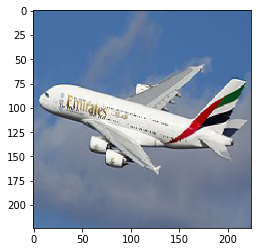

Filename: ./airbus380.jpg -- VGG 16 Model / Top Results: Label: airliner   Confidence: 0.9484437 / Next Results Label: wing   Confidence: 0.04797638
Filename: ./airbus380.jpg -- DenseNet 121 Model / Top Results: Label: airliner   Confidence: 0.7468952 / Next Results Label: space_shuttle   Confidence: 0.16545384
Filename: ./airbus380.jpg -- Resnet 50 Model / Top Results: Label: airliner   Confidence: 0.82813853 / Next Results Label: space_shuttle   Confidence: 0.091543354
./bed-bugsalt.jpg
image batch size (1, 224, 224, 3)


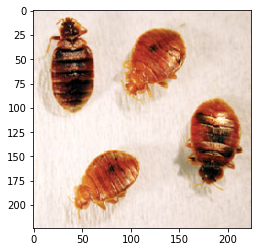

Filename: ./bed-bugsalt.jpg -- VGG 16 Model / Top Results: Label: tick   Confidence: 0.9442758 / Next Results Label: cockroach   Confidence: 0.036460303
Filename: ./bed-bugsalt.jpg -- DenseNet 121 Model / Top Results: Label: isopod   Confidence: 0.5396053 / Next Results Label: cockroach   Confidence: 0.24122426
Filename: ./bed-bugsalt.jpg -- Resnet 50 Model / Top Results: Label: isopod   Confidence: 0.6248546 / Next Results Label: cockroach   Confidence: 0.2586844
./tiger_shark.jpg
image batch size (1, 224, 224, 3)


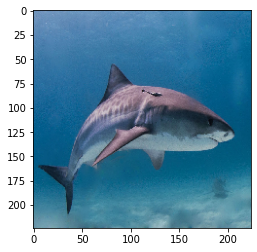

Filename: ./tiger_shark.jpg -- VGG 16 Model / Top Results: Label: tiger_shark   Confidence: 0.99276143 / Next Results Label: great_white_shark   Confidence: 0.0070846886
Filename: ./tiger_shark.jpg -- DenseNet 121 Model / Top Results: Label: tiger_shark   Confidence: 0.985402 / Next Results Label: great_white_shark   Confidence: 0.0137631595
Filename: ./tiger_shark.jpg -- Resnet 50 Model / Top Results: Label: tiger_shark   Confidence: 0.9978258 / Next Results Label: great_white_shark   Confidence: 0.0017840298
./airbus320.jpg
image batch size (1, 224, 224, 3)


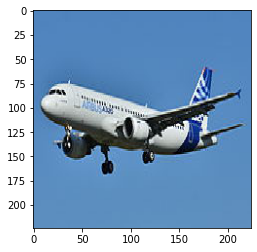

Filename: ./airbus320.jpg -- VGG 16 Model / Top Results: Label: airliner   Confidence: 0.9718863 / Next Results Label: wing   Confidence: 0.027803866
Filename: ./airbus320.jpg -- DenseNet 121 Model / Top Results: Label: airliner   Confidence: 0.99464005 / Next Results Label: wing   Confidence: 0.0023725266
Filename: ./airbus320.jpg -- Resnet 50 Model / Top Results: Label: airliner   Confidence: 0.9968545 / Next Results Label: wing   Confidence: 0.0026994536
./737-1.jpg
image batch size (1, 224, 224, 3)


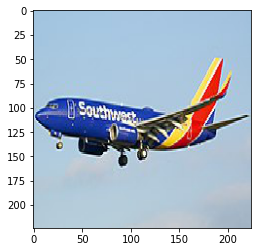

Filename: ./737-1.jpg -- VGG 16 Model / Top Results: Label: airliner   Confidence: 0.5277622 / Next Results Label: airship   Confidence: 0.25580466
Filename: ./737-1.jpg -- DenseNet 121 Model / Top Results: Label: airliner   Confidence: 0.8949055 / Next Results Label: airship   Confidence: 0.051240176
Filename: ./737-1.jpg -- Resnet 50 Model / Top Results: Label: airliner   Confidence: 0.9907918 / Next Results Label: wing   Confidence: 0.0077709267
./tank.jpg
image batch size (1, 224, 224, 3)


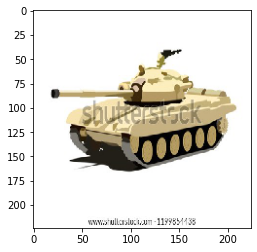

Filename: ./tank.jpg -- VGG 16 Model / Top Results: Label: tank   Confidence: 0.90953565 / Next Results Label: amphibian   Confidence: 0.043997727
Filename: ./tank.jpg -- DenseNet 121 Model / Top Results: Label: tank   Confidence: 0.9925488 / Next Results Label: half_track   Confidence: 0.004154573
Filename: ./tank.jpg -- Resnet 50 Model / Top Results: Label: tank   Confidence: 0.99615544 / Next Results Label: amphibian   Confidence: 0.0026051302
./finch from feeder.jpg
image batch size (1, 224, 224, 3)


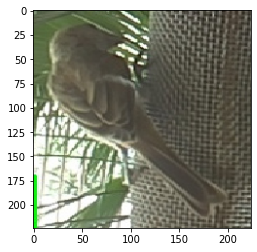

Filename: ./finch from feeder.jpg -- VGG 16 Model / Top Results: Label: house_finch   Confidence: 0.34107432 / Next Results Label: bulbul   Confidence: 0.092450716
Filename: ./finch from feeder.jpg -- DenseNet 121 Model / Top Results: Label: house_finch   Confidence: 0.3503832 / Next Results Label: partridge   Confidence: 0.20670184
Filename: ./finch from feeder.jpg -- Resnet 50 Model / Top Results: Label: house_finch   Confidence: 0.73955363 / Next Results Label: window_screen   Confidence: 0.09466294
./goldfinch.jpg
image batch size (1, 224, 224, 3)


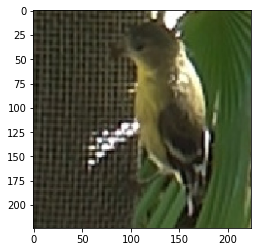

Filename: ./goldfinch.jpg -- VGG 16 Model / Top Results: Label: kite   Confidence: 0.26882005 / Next Results Label: hummingbird   Confidence: 0.23034109
Filename: ./goldfinch.jpg -- DenseNet 121 Model / Top Results: Label: fox_squirrel   Confidence: 0.52463526 / Next Results Label: goldfinch   Confidence: 0.15822825
Filename: ./goldfinch.jpg -- Resnet 50 Model / Top Results: Label: goldfinch   Confidence: 0.48646578 / Next Results Label: coucal   Confidence: 0.24770555
./747.jpg
image batch size (1, 224, 224, 3)


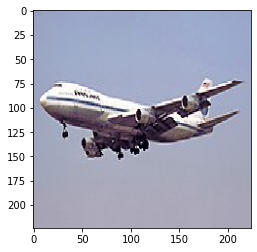

Filename: ./747.jpg -- VGG 16 Model / Top Results: Label: airliner   Confidence: 0.6478122 / Next Results Label: wing   Confidence: 0.1799359
Filename: ./747.jpg -- DenseNet 121 Model / Top Results: Label: airliner   Confidence: 0.8841276 / Next Results Label: warplane   Confidence: 0.088620044
Filename: ./747.jpg -- Resnet 50 Model / Top Results: Label: airliner   Confidence: 0.67896825 / Next Results Label: warplane   Confidence: 0.15575442
./dog.jpg
image batch size (1, 224, 224, 3)


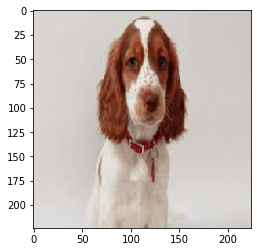

Filename: ./dog.jpg -- VGG 16 Model / Top Results: Label: Welsh_springer_spaniel   Confidence: 0.9789412 / Next Results Label: Sussex_spaniel   Confidence: 0.011244476
Filename: ./dog.jpg -- DenseNet 121 Model / Top Results: Label: Welsh_springer_spaniel   Confidence: 0.7772794 / Next Results Label: Sussex_spaniel   Confidence: 0.06503631
Filename: ./dog.jpg -- Resnet 50 Model / Top Results: Label: Welsh_springer_spaniel   Confidence: 0.71366334 / Next Results Label: English_springer   Confidence: 0.22106615
./707.jpg
image batch size (1, 224, 224, 3)


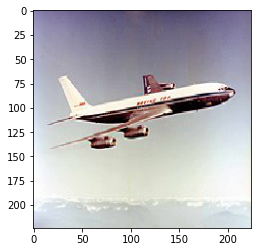

Filename: ./707.jpg -- VGG 16 Model / Top Results: Label: warplane   Confidence: 0.46649867 / Next Results Label: airliner   Confidence: 0.415093
Filename: ./707.jpg -- DenseNet 121 Model / Top Results: Label: space_shuttle   Confidence: 0.513181 / Next Results Label: airliner   Confidence: 0.24954812
Filename: ./707.jpg -- Resnet 50 Model / Top Results: Label: space_shuttle   Confidence: 0.58051425 / Next Results Label: warplane   Confidence: 0.2616568
./commercial_aircraft.jpg
image batch size (1, 224, 224, 3)


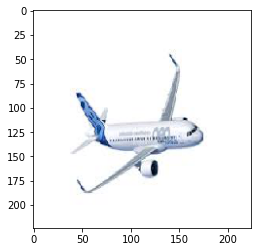

Filename: ./commercial_aircraft.jpg -- VGG 16 Model / Top Results: Label: airliner   Confidence: 0.74742013 / Next Results Label: space_shuttle   Confidence: 0.09704392
Filename: ./commercial_aircraft.jpg -- DenseNet 121 Model / Top Results: Label: airliner   Confidence: 0.48881158 / Next Results Label: space_shuttle   Confidence: 0.43818292
Filename: ./commercial_aircraft.jpg -- Resnet 50 Model / Top Results: Label: airliner   Confidence: 0.7506224 / Next Results Label: space_shuttle   Confidence: 0.2227779
./carrier.jpg
image batch size (1, 224, 224, 3)


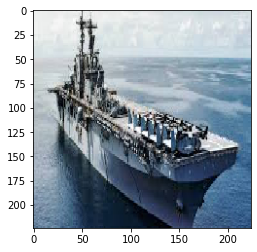

Filename: ./carrier.jpg -- VGG 16 Model / Top Results: Label: aircraft_carrier   Confidence: 0.99723274 / Next Results Label: dock   Confidence: 0.001174844
Filename: ./carrier.jpg -- DenseNet 121 Model / Top Results: Label: aircraft_carrier   Confidence: 0.9856213 / Next Results Label: drilling_platform   Confidence: 0.008499406
Filename: ./carrier.jpg -- Resnet 50 Model / Top Results: Label: aircraft_carrier   Confidence: 0.95077956 / Next Results Label: drilling_platform   Confidence: 0.043523323
./sub.jpg
image batch size (1, 224, 224, 3)


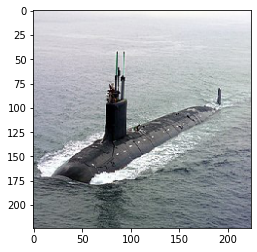

Filename: ./sub.jpg -- VGG 16 Model / Top Results: Label: submarine   Confidence: 0.99999785 / Next Results Label: breakwater   Confidence: 1.6416711e-06
Filename: ./sub.jpg -- DenseNet 121 Model / Top Results: Label: submarine   Confidence: 0.99998796 / Next Results Label: breakwater   Confidence: 7.483447e-06
Filename: ./sub.jpg -- Resnet 50 Model / Top Results: Label: submarine   Confidence: 1.0 / Next Results Label: breakwater   Confidence: 5.0553073e-13
./molly.jpg
image batch size (1, 224, 224, 3)


Filename: ./molly.jpg -- VGG 16 Model / Top Results: Label: Lhasa   Confidence: 0.78011996 / Next Results Label: Shih-Tzu   Confidence: 0.13574032
Filename: ./molly.jpg -- DenseNet 121 Model / Top Results: Label: Lhasa   Confidence: 0.7694179 / Next Results Label: Shih-Tzu   Confidence: 0.16634466
Filename: ./molly.jpg -- Resnet 50 Model / Top Results: Label: Lhasa   Confidence: 0.5429464 / Next Results Label: Maltese_dog   Confidence: 0.22682253
./air-combat.jpg
image batch size (1, 224, 224, 3)


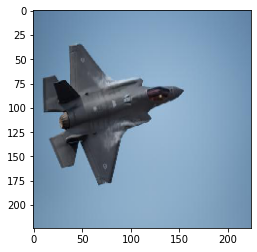

Filename: ./air-combat.jpg -- VGG 16 Model / Top Results: Label: warplane   Confidence: 0.9500171 / Next Results Label: wing   Confidence: 0.029028688
Filename: ./air-combat.jpg -- DenseNet 121 Model / Top Results: Label: warplane   Confidence: 0.9416925 / Next Results Label: wing   Confidence: 0.037430387
Filename: ./air-combat.jpg -- Resnet 50 Model / Top Results: Label: warplane   Confidence: 0.9600231 / Next Results Label: wing   Confidence: 0.01624164
./comet.jpg
image batch size (1, 224, 224, 3)


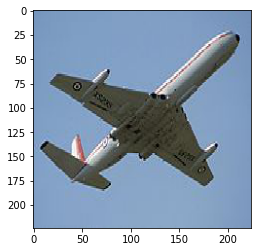

Filename: ./comet.jpg -- VGG 16 Model / Top Results: Label: airliner   Confidence: 0.6561087 / Next Results Label: wing   Confidence: 0.22670574
Filename: ./comet.jpg -- DenseNet 121 Model / Top Results: Label: airliner   Confidence: 0.60397744 / Next Results Label: space_shuttle   Confidence: 0.34004495
Filename: ./comet.jpg -- Resnet 50 Model / Top Results: Label: airliner   Confidence: 0.96926594 / Next Results Label: warplane   Confidence: 0.016210847
./787.jpg
image batch size (1, 224, 224, 3)


Filename: ./787.jpg -- VGG 16 Model / Top Results: Label: airliner   Confidence: 0.5722455 / Next Results Label: wing   Confidence: 0.19123745
Filename: ./787.jpg -- DenseNet 121 Model / Top Results: Label: airliner   Confidence: 0.40250143 / Next Results Label: space_shuttle   Confidence: 0.3879829
Filename: ./787.jpg -- Resnet 50 Model / Top Results: Label: airliner   Confidence: 0.522926 / Next Results Label: space_shuttle   Confidence: 0.25262848


In [ ]:
#  MAIN:  Look to see which .jpg files are loaded.  Right now I'm just showing the top two predicted labels with their probabilities.

import os
directory = '/content/images'

for file in os.listdir(directory):
    if file.endswith(".jpg") or file.endswith(".png"):
        f = (os.path.join("./", file))
        print(f)
        process_image(f)

# Load new images

To load new images, use the below code.  It will allow you to load images from your own computer.  Otherwise, you'll be able to test with the default images. 

In [ ]:
%cd /content/images
from google.colab import files
original = files.upload()
for fn in original.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(original[fn])))
!ls

/content/images


KeyboardInterrupt: ignored

In [ ]:
# Download an image from the internet
!wget -O /content/images/airbus380.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/A6-EDY_A380_Emirates_31_jan_2013_jfk_%288442269364%29_%28cropped%29.jpg/300px-A6-EDY_A380_Emirates_31_jan_2013_jfk_%288442269364%29_%28cropped%29.jpg"
!wget -O /content/images/737-1.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/N730SW_737-7H4.jpg/220px-N730SW_737-7H4.jpg"
!wget -O /content/images/comet.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/De_Havilland_DH-106_Comet_4C%2C_UK_-_Air_Force_AN1476165.jpg/220px-De_Havilland_DH-106_Comet_4C%2C_UK_-_Air_Force_AN1476165.jpg"
!wget -O /content/images/707.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Boeing_707_N68657_01.jpg/220px-Boeing_707_N68657_01.jpg"
!wget -O /content/images/747.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Pan_Am_Boeing_747-121_N732PA_Bidini.jpg/220px-Pan_Am_Boeing_747-121_N732PA_Bidini.jpg"
!wget -O /content/images/airbus320.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Airbus_A320-200_Airbus_Industries_%28AIB%29_%22House_colors%22_F-WWBA_-_MSN_001_%2810276181983%29.jpg/220px-Airbus_A320-200_Airbus_Industries_%28AIB%29_%22House_colors%22_F-WWBA_-_MSN_001_%2810276181983%29.jpg"
!wget -O /content/images/787.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Boeing_787_Dreamliner_arrival_Airventure_2011.jpg/1280px-Boeing_787_Dreamliner_arrival_Airventure_2011.jpg"
!wget -O /content/images/tiger_shark.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Tiger_shark.jpg/1024px-Tiger_shark.jpg"
!wget -O /content/images/tank.jpg 'https://image.shutterstock.com/image-vector/vector-illustration-tank-450w-1199854438.jpg'
#!wget -O /content/images/ddg.jpg "https://www.secnav.navy.mil/ig/PublishingImages/The-Arleigh-Burke-class-guided-missile-destroyer-USS-Ross-DDG%2071.jpg"
!wget -O /content/images/sub.jpg "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/US_Navy_040730-N-1234E-002_PCU_Virginia_%28SSN_774%29_returns_to_the_General_Dynamics_Electric_Boat_shipyard.jpg/300px-US_Navy_040730-N-1234E-002_PCU_Virginia_%28SSN_774%29_returns_to_the_General_Dynamics_Electric_Boat_shipyard.jpg"

--2021-10-28 16:49:00--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/A6-EDY_A380_Emirates_31_jan_2013_jfk_%288442269364%29_%28cropped%29.jpg/300px-A6-EDY_A380_Emirates_31_jan_2013_jfk_%288442269364%29_%28cropped%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10098 (9.9K) [image/jpeg]
Saving to: ‘/content/images/airbus380.jpg’

/content/images/air 100%[===================>]   9.86K  --.-KB/s    in 0.001s  

2021-10-28 16:49:00 (9.00 MB/s) - ‘/content/images/airbus380.jpg’ saved [10098/10098]

--2021-10-28 16:49:00--  https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/N730SW_737-7H4.jpg/220px-N730SW_737-7H4.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.11

In [ ]:
%rm ddg.jpg


# OpenCV Tutorials

### Experimental Section

Here are some techniques to segment out images in the hopes of improving classification accuracy.  This is in work.

In [ ]:
import cv2
import imutils
from google.colab.patches import cv2_imshow
import numpy as np

!git clone https://github.com/todnewman/images
%cd /content/images
!ls -l
#reading the image 
#img = '/content/images/Saturday_08_June_2019_12:00:06PM.jpg'
img = '/content/images/finch from feeder.jpg'
image = cv2.imread(img)
edged = cv2.Canny(image, 10, 250)
cv2_imshow(edged)
cv2.waitKey(0)

#applying closing function 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
cv2_imshow(closed)
cv2.waitKey(0)

#finding_contours 

cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
cv2_imshow(image)

for (i, c) in enumerate(cnts):
    # draw the contour
    ((x, y), _) = cv2.minEnclosingCircle(c)
    cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
import cv2 
import os
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage


def watershed_segment(img):
    image = cv2.imread(img)
    
    spatial_radius = 5
    color_radius = 500
    
    #
    #   The output of this function is the filtered “posterized” image with 
    #   color gradients and fine-grain texture flattened
    #
    shifted = cv2.pyrMeanShiftFiltering(image,spatial_radius,color_radius)
    cv2_imshow(image)

    # convert the mean shift image to grayscale, then apply
    # Otsu's thresholding
    '''gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh)'''
    
    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    cv2_imshow(thresh)

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    print("[INFO] {} unique contours found".format(len(cnts)))

    # loop over the contours
    for (i, c) in enumerate(cnts):
        # draw the contour
        ((x, y), _) = cv2.minEnclosingCircle(c)
        cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

    # show the output image
    cv2_imshow(image)
    
    # compute the exact Euclidean distance from every binary
    # pixel to the nearest zero pixel, then find peaks in this
    # distance map
    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=20,
        labels=thresh)

    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

    # loop over the unique labels returned by the Watershed
    # algorithm
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue

        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # draw a circle enclosing the object
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(image, (int(x), int(y)), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # show the output image
    cv2_imshow(image)
    cv2.waitKey(0)
    
    
directory = '/content/images'

for file in os.listdir(directory):
    if file.endswith(".jpg"):
        f = (os.path.join("./", file))
        watershed_segment(f)


In [ ]:
def watershed_2(img):
    image = cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=10)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    cv2_imshow(sure_bg)
    cv2_imshow(sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(image,markers)
    image[markers == -1] = [0,255,0]


    cv2_imshow(image)
    cv2.waitKey(0)
    
directory = '/content/images'

for file in os.listdir(directory):
    if file.endswith(".jpg"):
        f = (os.path.join("./", file))
        watershed_2(f)


In [ ]:
%ls

In [ ]:
%rm *.png

In [ ]:
%ls -lat


In [ ]:
from IPython.display import Image
Image('6.png')